# Can the number of "fake" iterations in Dyna be reduced when the model predicts further in the future ?

In class we discussed that TD methods can also be used to learn a model of the environment which can be used with model based RL architectures. Model-based reinforcement learning allows us to elegantly integrate planning into a real-time learning and decision-making agent. DYNA is one of the preferred architectures for this.

Intuitively, a model based on cumulative return from 'n'-steps would provide information 'n' temporal steps into future and hence the planning updates should be more informative. 

Here, I have an implementation of DYNA with a model based on n-step returns.



Some imports

In [19]:
import numpy as np
import matplotlib.pyplot
%matplotlib inline
#plt.style.use('ggplot')

A 5X8 grid world Environment. There are some walls to prohibit movement from some states in a particular directions. Actions represent movement in 4 cardinal directions.

In [20]:
# Environment is a 5X8 gridworld with some forbidden states

forbidden_states = [10, 18, 26, 6, 14, 22, 11, 12, 29]
start_state = 16
goal_state = 7


# Actions

UP      = 0
DOWN    = 1
LEFT    = 2
RIGHT   = 3

ACTIONS = { UP:-8, DOWN:8, LEFT:-1, RIGHT:1 }


#transitions

def newState(state, action):
    _s = state + ACTIONS[action]
    if action in [LEFT, RIGHT] and int(_s/8) != int(state/8) or _s in forbidden_states or _s<0 or _s>=40:
        # wall
        return state
    return _s


# Action value function

EPSILON = 1

Q = np.zeros((40,4))

def e_greedy_policy(state):
    if np.random.random()<EPSILON:
        return np.random.randint(len(ACTIONS))
    return Q[state].argmax()

def print_policy(q):
    policy = ['U', 'D', 'L', 'R']
    for state in range(40):
        if state in forbidden_states:
            print " ",
        else:
            print policy[q[state].argmax()],
        print "\t",
        if (state+1)%8==0:
            print

In [21]:
def print_gridworld():
    for state in range(40):
        if state in forbidden_states:
            print "W ",
        elif state == start_state:
            print "S ",
        elif state == goal_state:
            print "G ",
        else:            
            print state,
        print "\t",
        if (state+1)%8==0:
            print

print "Grid World - \n"
print_gridworld()

Grid World - 

0 	1 	2 	3 	4 	5 	W  	G  	
8 	9 	W  	W  	W  	13 	W  	15 	
S  	17 	W  	19 	20 	21 	W  	23 	
24 	25 	W  	27 	28 	W  	30 	31 	
32 	33 	34 	35 	36 	37 	38 	39 	


Some helper methods

In [5]:
def SarsaAgent(alpha=0.08, gamma=0.9, noOfEpisodes = 500):
    times = []
    global Q
    Q = np.zeros((40,4))
    global EPSILON
    EPSILON = 1 
    for epoch in range(noOfEpisodes):
        EPSILON = EPSILON*.98
        s = start_state
        time = 0
        while(s!=goal_state):
            time += 1
            a = e_greedy_policy(s)
            s_ = newState(s,ACTIONS[a])
            a_ = e_greedy_policy(s_)
            # -1 reward at every time step
            Q[s,a] += alpha*(-1 + gamma*Q[s_,a_] - Q[s,a])
            s = s_
        times.append(time)
    print "SARSA policy:"
    print_policy(Q)
    print 
    return times

def QLearning(alpha=0.08, gamma=0.9, noOfEpisodes = 500):
    times = []
    global Q
    Q = np.zeros((40,4))
    global EPSILON
    EPSILON = 1 
    for epoch in range(noOfEpisodes):
        EPSILON = EPSILON*.98
        s = start_state
        time = 0
        while(s!=goal_state):
            time += 1
            a = e_greedy_policy(s)
            s_ = newState(s,ACTIONS[a])
            # -1 reward at every time step
            Q[s,a] += alpha*(-1 + gamma*Q[s_].max() - Q[s,a])
            s = s_
        times.append(time)
    print "Q_learning policy:"
    print_policy(Q)
    print 
    return times

DYNA implementation

In [22]:
class DYNA(object):
    def __init__(self, learningAlgorithm="SARSA", noOfPlanningSteps=5, n=1, alpha=0.05, gamma=0.9, noOfEpisodes=500):
        self.learningUpdate = learningAlgorithm
        self.noOfPlanningSteps = noOfPlanningSteps
        self.n = n
        self.alpha = alpha
        self.gamma = gamma
        self.noOfEpisodes = noOfEpisodes
        self.theta = np.zeros((40,4))
        self.nStepTarget = np.zeros((40,4)) # n-step target
        self.policy = self.e_greedy_policy
        self.EPSILON = 1

    def e_greedy_policy(self, state):
        if np.random.random()<self.EPSILON:
            return np.random.randint(len(ACTIONS))
        return self.theta[state].argmax()

    def print_policy(self):
        policy = ['U', 'D', 'L', 'R']
        for state in range(40):
            if state in forbidden_states:
                print " ",
            else:
                print policy[self.theta[state].argmax()],
            print "\t",
            if (state+1)%8==0:
                print

    def randomPlanning(self):
        for i in range(self.noOfPlanningSteps):
            s = None
            while not s:
                s_ = np.random.randint(40)
                s = s_ if s_ not in forbidden_states and s != goal_state else None
            a = np.random.randint(len(ACTIONS))
            target = self.nStepTarget[s,a]
            self.theta[s,a] += self.alpha * (target-self.theta[s,a])

    def episode(self, planning=False):
        s = start_state
        a = self.policy(s)
        r = 0
        t = 0
        
        states  = []
        actions = []
        rewards = []

        while s != goal_state:
            t += 1
            states.append(s)
            actions.append(a)
            rewards.append(r)
            r = -1
            s_ = newState(s,a)
            a_ = self.policy(s_)
            if self.learningUpdate == "SARSA":
                #SARSA update to Q
                self.theta[s,a] += self.alpha*(r+self.gamma*self.theta[s_,a_]-self.theta[s,a])
            else:
                #Q-Learning update to Q
                self.theta[s,a] += self.alpha*(r+self.gamma*self.theta[s_].max()-self.theta[s,a])
            s = s_
            a = self.policy(s)
            if planning:
                self.randomPlanning()

            if t>self.n:
                ret = np.dot( rewards[(t-self.n):t], np.power(self.gamma, range(self.n)) ) + ( self.gamma**self.n * self.theta[states[-1]].max() )
                self.nStepTarget[states[t-self.n-1],actions[t-self.n-1]] += 0.2*(ret-self.nStepTarget[states[t-self.n-1],actions[t-self.n-1]])

        rewards.append(r)

        for n in range(self.n,0,-1):
            ret = np.dot( rewards[-n:], np.power(self.gamma, range(n)) )
            self.nStepTarget[states[-n],actions[-n]] += 0.2*(ret-self.nStepTarget[states[-n],actions[-n]])
        return t

    def start(self):
        """
        No planning steps for initial 10 episodes
        """
        times = []
        for ep in range(self.noOfEpisodes):
            times.append(self.episode(ep>=10))
            self.EPSILON *= 0.98
        return times


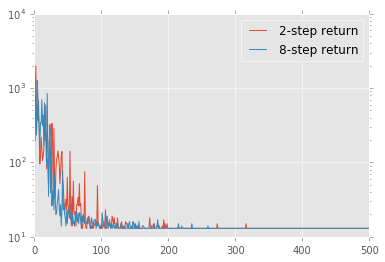

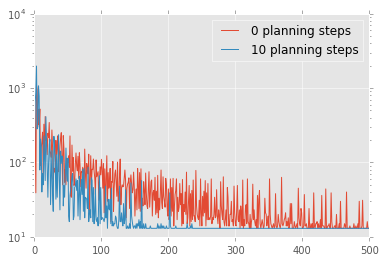

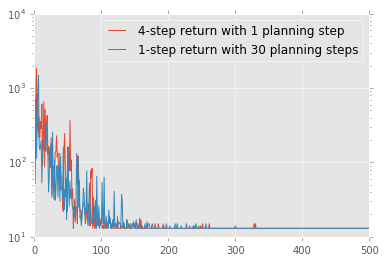

Policy of agent with 4-step return model and 1 planning step-
U 	R 	U 	D 	R 	D 	  	U 	
D 	D 	  	  	  	D 	  	U 	
D 	D 	  	D 	D 	L 	  	U 	
R 	D 	  	D 	D 	  	R 	U 	
R 	R 	R 	R 	R 	R 	R 	U 	

Policy of agent with 1-step return model and 30 planning step-
L 	R 	R 	R 	L 	U 	  	U 	
L 	L 	  	  	  	L 	  	U 	
D 	D 	  	L 	D 	R 	  	U 	
D 	D 	  	R 	D 	  	R 	U 	
R 	R 	R 	R 	R 	R 	R 	U 	


In [23]:
def differntNStepReturns():
    for n in [2,8]:
        agent = DYNA(n=n)
        plt.plot(agent.start(), label=str(n)+"-step return")
    plt.yscale('log')
    plt.legend()
    plt.show()

def differentPlanningSteps():
    for k in [0,10]:
        agent = DYNA(noOfPlanningSteps=k)
        plt.plot(agent.start(), label=str(k)+" planning steps")
    plt.yscale("log")
    plt.legend()
    plt.show()

def showDown():
    agent1 = DYNA(n=4, noOfPlanningSteps=1)
    agent2 = DYNA(n=1, noOfPlanningSteps=30)
    plt.plot(agent1.start(), label="4-step return with 1 planning step")
    plt.plot(agent2.start(), label="1-step return with 30 planning steps")
    plt.yscale("log")
    plt.legend()
    plt.show()

    print "Policy of agent with 4-step return model and 1 planning step-"
    agent1.print_policy()
    print
    print "Policy of agent with 1-step return model and 30 planning step-"
    agent2.print_policy()


differntNStepReturns()
differentPlanningSteps()
showDown()

# Discussion

First graph shows the convergence to optimal policy over the grid with supported with 5 planning steps per real step. The agent which uses 8-step return converges significantly before one using a 2-step return model.

Second plot highlights the effectiveness of planning. The agent with 10 planning steps per real step converges way before the agent not using planning. 

In the last plot a agent using just 1 planning step with a 4-step return based model performs almost equivalent to one with 30 planning steps using a model predicting very next reward. This answers the ques - yes, we can reduce the number of fake iterations when using a model predicting further in the future.